# Deep Learning for Breast Cancer Detection

**Goal.** Build a reproducible pipeline to classify CBIS-DDSM mammogram images as *benign* vs *malignant*.

**Iterations covered**
1. Baseline scratch CNN on full mammograph images  
2. Scratch CNN on **augmented images** with **compact GAP head**  
3. Baseline scratch CNN on ROIs  
4. Transfer learning with **VGG16 (frozen backbone)** on **ROIs** 


**_______________________________________________________________________________________________________________________________**

<br>**Import libraries**

In [1]:
import os
import cv2
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, regularizers, models, optimizers
from tensorflow.keras.applications import VGG16

<br>**Define functions essential for importing images and labels**

In [2]:
# Function to load and preprocess grayscale image
def preprocess_image(image_path, target_size=(224, 224)):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = image / 255.0  # Normalize pixel values
    image_resized = cv2.resize(image, target_size)
    return np.expand_dims(image_resized, axis=-1)  # Add channel dimension

In [3]:
# Extract the label (benign or malignant) from annotation JSON
def extract_label(json_data):
    labels = [tag["name"] for tag in json_data.get("tags", [])]
    if "malignant" in labels:
        return "malignant"
    elif "benign" in labels:
        return "benign"
    else:
        return "unknown"

In [4]:
def load_dataset(image_dir, ann_dir):
    X = []
    y = []
    filenames = []

    for fname in os.listdir(image_dir):
        if fname.endswith(".png"):
            image_path = os.path.join(image_dir, fname)
            ann_path = os.path.join(ann_dir, fname + ".json")

            # Check if annotation exists
            if not os.path.exists(ann_path):
                print(f"Warning: Annotation missing for {fname}")
                continue

            # Load annotation
            with open(ann_path, 'r') as f:
                ann = json.load(f)

            # Extract label
            label = extract_label(ann)
            if label not in ["benign", "malignant"]:
                continue

            # Preprocess image
            image = preprocess_image(image_path)
            X.append(image)
            y.append(1 if label == "malignant" else 0)
            filenames.append(fname)

    return np.array(X), np.array(y), filenames


<br>**Create Training and Test dataset from locally downloaded Supervisely database**

In [5]:
# Load from your training folder
train_img_path = "DDSM/train/img"
train_ann_path = "DDSM/train/ann"

X_train, y_train, filenames_train = load_dataset(train_img_path, train_ann_path)

print("Training Dataset loaded:")
print("Images:", X_train.shape)
print("Labels:", y_train.shape)

Training Dataset loaded:
Images: (2137, 224, 224, 1)
Labels: (2137,)


In [6]:
# Load test dataset
test_img_path = "DDSM/test/img"
test_ann_path = "DDSM/test/ann"

X_test, y_test, filenames_test = load_dataset(test_img_path, test_ann_path)
print("Test Dataset loaded:")
print("Images:", X_test.shape)
print("Labels:", y_test.shape)

Test Dataset loaded:
Images: (566, 224, 224, 1)
Labels: (566,)


<br>**View random images from dataset to ensure integrity of data import**<br>
**Manually confirmed that labels (malignant vs benign) matched the corresponding images** 

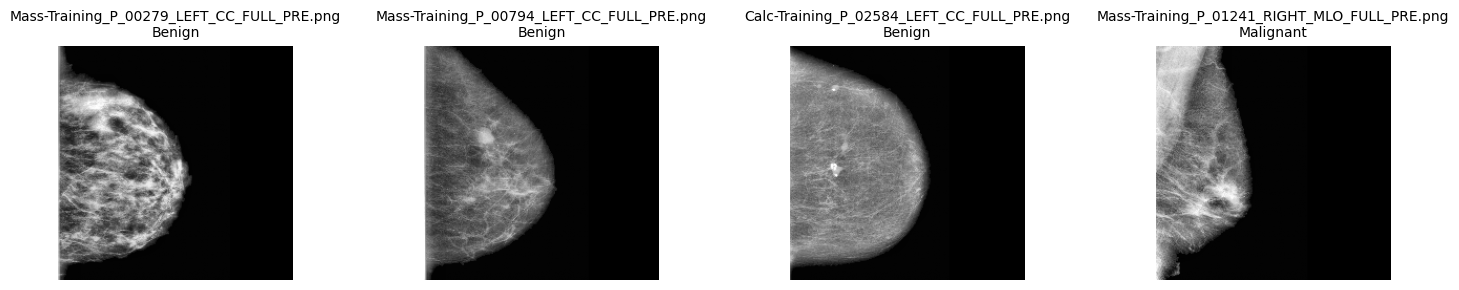

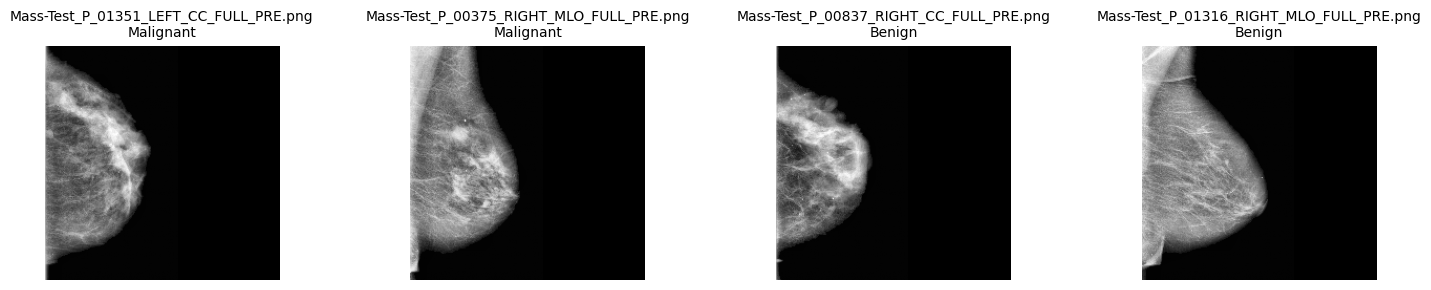

In [7]:
# Display random images with labels to verify correctness

def show_images(X, y, filenames, num_examples=4):
    indices = random.sample(range(len(X)), num_examples)

    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(indices):
        image = X[idx].squeeze()
        label = 'Malignant' if y[idx] == 1 else 'Benign'
        title = f"{filenames[idx]}\n{label}"

        plt.subplot(1, num_examples, i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(title, fontsize=10)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Show sample images
show_images(X_train, y_train, filenames_train)
show_images(X_test, y_test, filenames_test)

<br>**View class distribution to ensure class balance**

In [8]:

def print_class_distribution(y_train, y_test):
    train_classes, train_counts = np.unique(y_train, return_counts=True)
    test_classes, test_counts = np.unique(y_test, return_counts=True)

    print("--Class Distribution--")
    print("Train Set:")
    for cls, count in zip(train_classes, train_counts):
        label = "Malignant" if cls == 1 else "Benign"
        print(f"  {label} ({cls}): {count} samples")

    print("\nTest Set:")
    for cls, count in zip(test_classes, test_counts):
        label = "Malignant" if cls == 1 else "Benign"
        print(f"  {label} ({cls}): {count} samples")

# Run the function
print_class_distribution(y_train, y_test)



--Class Distribution--
Train Set:
  Benign (0): 1033 samples
  Malignant (1): 1104 samples

Test Set:
  Benign (0): 303 samples
  Malignant (1): 263 samples


<br>**Building and testing the PROTOTYPE MODEL**<br>
**Description:** Scratch model without augmentation 

In [9]:

# Build CNN model
def build_cnn_model(input_shape=(224, 224, 1)):
    model = Sequential()

    # First conv block
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Second conv block
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Third conv block
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Fourth conv block
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flatten and dense
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))  # Binary classification

    return model


# Create and compile the model
cnn_model = build_cnn_model()
cnn_model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

# Print model summary
cnn_model.summary()


C:\Users\ganatrh\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 222, 222, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 109, 109, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 52, 52, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 24, 24, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36864)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       2,359,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,749,185 (10.49 MB)

 Trainable params: 2,748,225 (10.48 MB)

 Non-trainable params: 960 (3.75 KB)

In [10]:
history = cnn_model.fit(
    X_train, y_train,
    epochs=40,
    batch_size=128,
    verbose=1
)


Epoch 1/40
17/17 ━━━━━━━━━━━━━━━━━━━━ 119s 7s/step - accuracy: 0.5033 - loss: 1.7271
Epoch 2/40
17/17 ━━━━━━━━━━━━━━━━━━━━ 108s 6s/step - accuracy: 0.5190 - loss: 0.6903
Epoch 3/40
17/17 ━━━━━━━━━━━━━━━━━━━━ 143s 6s/step - accuracy: 0.5185 - loss: 0.6905
Epoch 4/40
17/17 ━━━━━━━━━━━━━━━━━━━━ 106s 6s/step - accuracy: 0.5198 - loss: 0.6858
Epoch 5/40
17/17 ━━━━━━━━━━━━━━━━━━━━ 144s 6s/step - accuracy: 0.5525 - loss: 0.6799
Epoch 6/40
17/17 ━━━━━━━━━━━━━━━━━━━━ 139s 6s/step - accuracy: 0.5555 - loss: 0.6796
Epoch 7/40
17/17 ━━━━━━━━━━━━━━━━━━━━ 103s 6s/step - accuracy: 0.5648 - loss: 0.6712
Epoch 8/40
17/17 ━━━━━━━━━━━━━━━━━━━━ 101s 6s/step - accuracy: 0.5696 - loss: 0.6651
Epoch 9/40
17/17 ━━━━━━━━━━━━━━━━━━━━ 104s 6s/step - accuracy: 0.5862 - loss: 0.6375
Epoch 10/40
17/17 ━━━━━━━━━━━━━━━━━━━━ 109s 6s/step - accuracy: 0.5883 - loss: 0.6448
Epoch 11/40
17/17 ━━━━━━━━━━━━━━━━━━━━ 103s 6s/step - accuracy: 0.6051 - loss: 0.6240
Epoch 12/40
17/17 ━━━━━━━━━━━━━━━━━━━━ 103s 6s/step - accuracy:

In [11]:
# Plot training accuracy and loss curves
def plot_training_curves(history):
    acc = history.history['accuracy']
    loss = history.history['loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training accuracy')
    plt.title('Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'ro-', label='Training loss')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()


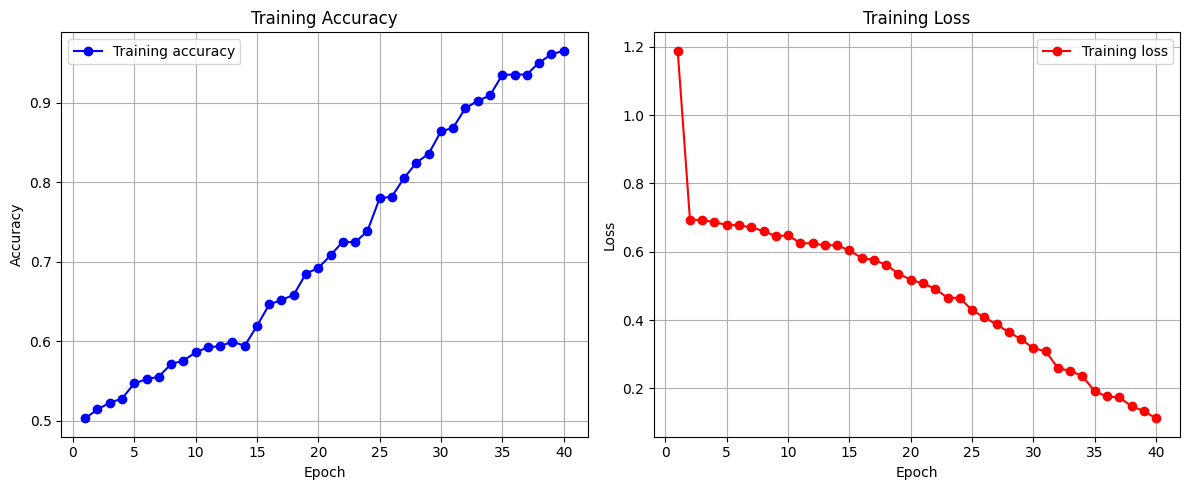

In [12]:
# Call the function
plot_training_curves(history)

<br>**Evaluating the PROTOTYPE MODEL on test data, and generating evaluation metrics inlcuding confusion matrix**

In [13]:
# Evaluate model on test data
test_loss, test_accuracy = cnn_model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")



18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 286ms/step - accuracy: 0.5334 - loss: 1.6535
Test Accuracy: 0.5371
Test Loss: 1.6022


18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 293ms/step
              precision    recall  f1-score   support

      Benign       0.54      1.00      0.70       303
   Malignant       0.67      0.01      0.02       263

    accuracy                           0.54       566
   macro avg       0.60      0.50      0.36       566
weighted avg       0.60      0.54      0.38       566



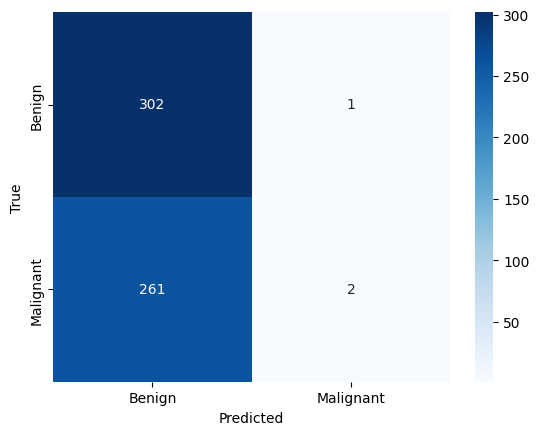

In [14]:
# Predictions
y_pred_probs = cnn_model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int).ravel()

# Classification report
print(classification_report(y_test, y_pred, target_names=["Benign","Malignant"]))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Benign","Malignant"],
            yticklabels=["Benign","Malignant"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


<br>**Building and training AUGMENTED MODEL with GAP**<br>
**Description:** light augmentation with horizontal flip, rotation, and zoom. Also, Flatten replaced by GAP

In [15]:
IMG_SIZE = 224  # keep consistent with the preprocessing

# Light augmentation to improve generalization
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
], name="augmentation")

def build_augmented_cnn(input_shape=(IMG_SIZE, IMG_SIZE, 1), l2=1e-4, drop=0.5, lr=1e-3):
    inputs = layers.Input(shape=input_shape)
    x = data_augmentation(inputs)

    x = layers.Conv2D(32, (3,3), padding="same", activation="relu",
                      kernel_regularizer=regularizers.l2(l2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(64, (3,3), padding="same", activation="relu",
                      kernel_regularizer=regularizers.l2(l2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(128, (3,3), padding="same", activation="relu",
                      kernel_regularizer=regularizers.l2(l2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    # GlobalAveragePooling2D helps reduce parameters vs Flatten
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(drop)(x)
    x = layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(l2))(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = models.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr),
        loss="binary_crossentropy",
        metrics=[tf.keras.metrics.BinaryAccuracy(name="accuracy"),
                 tf.keras.metrics.AUC(name="auc")]
    )
    return model



In [16]:
augmented_model = build_augmented_cnn()
augmented_model.summary()

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ augmentation (Sequential)            │ (None, 224, 224, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 224, 224, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 101,889 (398.00 KB)

 Trainable params: 101,441 (396.25 KB)

 Non-trainable params: 448 (1.75 KB)

In [17]:
history2 = augmented_model.fit(
    X_train, y_train,
    epochs=40,
    batch_size=32,
    verbose=1
)

Epoch 1/40
67/67 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - accuracy: 0.5206 - auc: 0.5202 - loss: 0.7240
Epoch 2/40
67/67 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step - accuracy: 0.5543 - auc: 0.5657 - loss: 0.7097
Epoch 3/40
67/67 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.5534 - auc: 0.5752 - loss: 0.7049
Epoch 4/40
67/67 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - accuracy: 0.5678 - auc: 0.5767 - loss: 0.7050
Epoch 5/40
67/67 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - accuracy: 0.5862 - auc: 0.6161 - loss: 0.6922
Epoch 6/40
67/67 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - accuracy: 0.5847 - auc: 0.6046 - loss: 0.6932
Epoch 7/40
67/67 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.5737 - auc: 0.5904 - loss: 0.6995
Epoch 8/40
67/67 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.5844 - auc: 0.5947 - loss: 0.6944
Epoch 9/40
67/67 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.5743 - auc: 0.6142 - loss: 0.6880
Epoch 10/40
67/67 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - accuracy: 0.5494 - auc: 0.5508 - loss: 0.7059
Epoch 11/40
67/67 

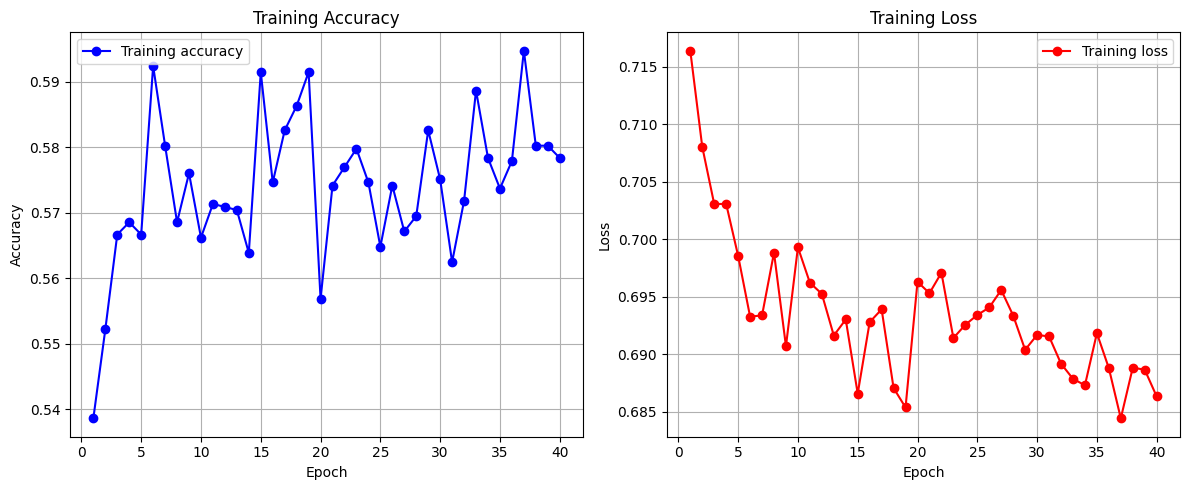

In [18]:
plot_training_curves(history2)

<br>**Evaluating AUGMENTED MODEL on test data, generating evaluation metrics and confusion matrix**

In [22]:
results = augmented_model.evaluate(X_test, y_test, verbose=1)
test_loss, test_accuracy = results[0], results[1]
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 250ms/step - accuracy: 0.5258 - auc: 0.5372 - loss: 0.7117
Test Accuracy: 0.5124
Test Loss: 0.7139


18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 241ms/step
              precision    recall  f1-score   support

      Benign       0.60      0.27      0.37       303
   Malignant       0.48      0.79      0.60       263

    accuracy                           0.51       566
   macro avg       0.54      0.53      0.49       566
weighted avg       0.55      0.51      0.48       566



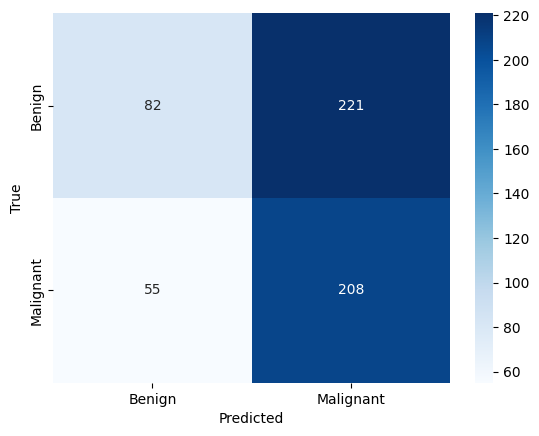

In [20]:
# Predictions
y_pred_probs = augmented_model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int).ravel()

# Classification report
print(classification_report(y_test, y_pred, target_names=["Benign","Malignant"]))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Benign","Malignant"],
            yticklabels=["Benign","Malignant"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

<br>**Building new dataframes for ROI images only, correctly linking ROI images to their correct label (malignant vs benign)**

In [23]:
# Load the dicom_info.csv file
dicom_info = pd.read_csv("csv/dicom_info.csv")

# Look at the columns to verify structure
print("Columns in dicom_info:", dicom_info.columns.tolist())
print("Total entries:", len(dicom_info))

# Count how many entries are crops vs full mammograms vs ROI images
# This comes from the 'SeriesDescription' column (cropped images, full mammogram images, ROI etc.)
counts = dicom_info['SeriesDescription'].value_counts(dropna=False)
print("\nCounts by SeriesDescription:")
print(counts)


Columns in dicom_info: ['file_path', 'image_path', 'AccessionNumber', 'BitsAllocated', 'BitsStored', 'BodyPartExamined', 'Columns', 'ContentDate', 'ContentTime', 'ConversionType', 'HighBit', 'InstanceNumber', 'LargestImagePixelValue', 'Laterality', 'Modality', 'PatientBirthDate', 'PatientID', 'PatientName', 'PatientOrientation', 'PatientSex', 'PhotometricInterpretation', 'PixelRepresentation', 'ReferringPhysicianName', 'Rows', 'SOPClassUID', 'SOPInstanceUID', 'SamplesPerPixel', 'SecondaryCaptureDeviceManufacturer', 'SecondaryCaptureDeviceManufacturerModelName', 'SeriesDescription', 'SeriesInstanceUID', 'SeriesNumber', 'SmallestImagePixelValue', 'SpecificCharacterSet', 'StudyDate', 'StudyID', 'StudyInstanceUID', 'StudyTime']
Total entries: 10237

Counts by SeriesDescription:
SeriesDescription
cropped images           3567
ROI mask images          3247
full mammogram images    2857
NaN                       566
Name: count, dtype: int64


In [24]:
# Keep only rows where SeriesDescription indicates cropped images
dicom_crops = dicom_info[dicom_info['SeriesDescription'] == "cropped images"].copy()

# Print how many rows remain
print("Number of cropped images:", len(dicom_crops))


Number of cropped images: 3567


In [25]:
# Load the four case description CSVs
calc_train = pd.read_csv("csv/calc_case_description_train_set.csv")
calc_test  = pd.read_csv("csv/calc_case_description_test_set.csv")
mass_train = pd.read_csv("csv/mass_case_description_train_set.csv")
mass_test  = pd.read_csv("csv/mass_case_description_test_set.csv")

# Combine them into one DataFrame
case_df = pd.concat([calc_train, calc_test, mass_train, mass_test], ignore_index=True)

# Extract the "ID of interest" from cropped image file path
# The format is ".../<ID of interest>/something.dcm"
case_df["SeriesInstanceUID"] = case_df["cropped image file path"].apply(lambda x: x.split("/")[2])

# Now merge pathology labels into dicom_crops
dicom_crops = dicom_crops.merge(
    case_df[["SeriesInstanceUID", "pathology"]],
    on="SeriesInstanceUID",
    how="left"
)

# Check how many matched successfully
print("After merge, dicom_crops shape:", dicom_crops.shape)
print(dicom_crops["pathology"].value_counts(dropna=False))


After merge, dicom_crops shape: (3567, 39)
pathology
MALIGNANT                  1456
BENIGN                     1429
BENIGN_WITHOUT_CALLBACK     681
NaN                           1
Name: count, dtype: int64


In [26]:
dicom_crops.head()

,file_path,image_path,AccessionNumber,BitsAllocated,BitsStored,BodyPartExamined,Columns,ContentDate,ContentTime,ConversionType,...,SeriesDescription,SeriesInstanceUID,SeriesNumber,SmallestImagePixelValue,SpecificCharacterSet,StudyDate,StudyID,StudyInstanceUID,StudyTime,pathology
0,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.12930...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129308...,NaN,16,16,BREAST,351,20160426,131732.685,WSD,...,cropped images,1.3.6.1.4.1.9590.100.1.2.129308726812851964007...,1,23078,ISO_IR 100,20160720.0,DDSM,1.3.6.1.4.1.9590.100.1.2.271867287611061855725...,214951.0,BENIGN
1,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.38118...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...,NaN,16,16,BREAST,97,20160503,115347.770,WSD,...,cropped images,1.3.6.1.4.1.9590.100.1.2.381187369611524586537...,1,32298,ISO_IR 100,20170829.0,DDSM,1.3.6.1.4.1.9590.100.1.2.335006093711888937440...,180109.0,BENIGN_WITHOUT_CALLBACK
2,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.15333...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.153339...,NaN,16,16,BREAST,393,20160503,111620.055,WSD,...,cropped images,1.3.6.1.4.1.9590.100.1.2.153339052913121382622...,1,44323,ISO_IR 100,20170830.0,DDSM,1.3.6.1.4.1.9590.100.1.2.157384031212566921514...,215032.0,BENIGN
3,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.17899...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.178994...,NaN,16,16,BREAST,611,20160503,122938.838,WSD,...,cropped images,1.3.6.1.4.1.9590.100.1.2.178994714611485132105...,1,24057,ISO_IR 100,20170830.0,DDSM,1.3.6.1.4.1.9590.100.1.2.250103550412831547020...,215300.0,MALIGNANT
4,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.41183...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.411833...,NaN,16,16,BREAST,809,20160503,131321.302,WSD,...,cropped images,1.3.6.1.4.1.9590.100.1.2.411833492612373627114...,1,0,ISO_IR 100,20170830.0,DDSM,1.3.6.1.4.1.9590.100.1.2.407544576612957992910...,215430.0,BENIGN


In [27]:
# Drop rows where pathology is "BENIGN_WITHOUT_CALLBACK" or NaN
dicom_crops = dicom_crops[
    (dicom_crops["pathology"].notna()) & 
    (dicom_crops["pathology"] != "BENIGN_WITHOUT_CALLBACK")
].copy()

# Reset index to keep things tidy
dicom_crops.reset_index(drop=True, inplace=True)

# Show remaining pathology distribution
print("Remaining rows after filtering:", len(dicom_crops))
print(dicom_crops["pathology"].value_counts())


Remaining rows after filtering: 2885
pathology
MALIGNANT    1456
BENIGN       1429
Name: count, dtype: int64


In [28]:
# Map pathology to binary: MALIGNANT=1, BENIGN=0
label_map = {"MALIGNANT": 1, "BENIGN": 0}

dicom_crops["label"] = dicom_crops["pathology"].map(label_map)

# Verify mapping
print("Pathology distribution (string labels):")
print(dicom_crops["pathology"].value_counts())

print("\nPathology distribution (binary labels):")
print(dicom_crops["label"].value_counts())


Pathology distribution (string labels):
pathology
MALIGNANT    1456
BENIGN       1429
Name: count, dtype: int64

Pathology distribution (binary labels):
label
1    1456
0    1429
Name: count, dtype: int64


In [29]:


# Parameters
IMG_SIZE = 224  # size to resize all images

# Fix the image path: remove the "CBIS-DDSM/" prefix
dicom_crops["fixed_image_path"] = dicom_crops["image_path"].str.replace("CBIS-DDSM/", "", regex=False)

# Function to load and preprocess an image
def load_and_preprocess_image(img_path, size=IMG_SIZE):
    try:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # load as grayscale
        img = cv2.resize(img, (size, size))               # resize
        img = img.astype("float32") / 255.0               # normalize to [0,1]
        img = np.expand_dims(img, axis=-1)                # add channel dim (H, W, 1)
        return img
    except Exception as e:
        print("Error loading:", img_path, e)
        return None

# Iterate and build dataset
X, y = [], []
for _, row in tqdm(dicom_crops.iterrows(), total=len(dicom_crops)):
    img = load_and_preprocess_image(row["fixed_image_path"])
    if img is not None:
        X.append(img)
        y.append(row["label"])

X = np.array(X)
y = np.array(y)

print("Final dataset shapes:")
print("X:", X.shape)
print("y:", y.shape)


100%|█████████████████████████████████████████████████████████████████████████████| 2885/2885 [00:09<00:00, 316.81it/s]


Final dataset shapes:
X: (2885, 224, 224, 1)
y: (2885,)


<br>**Display random images from ROI dataset and manually confirm correctnes of class label** 

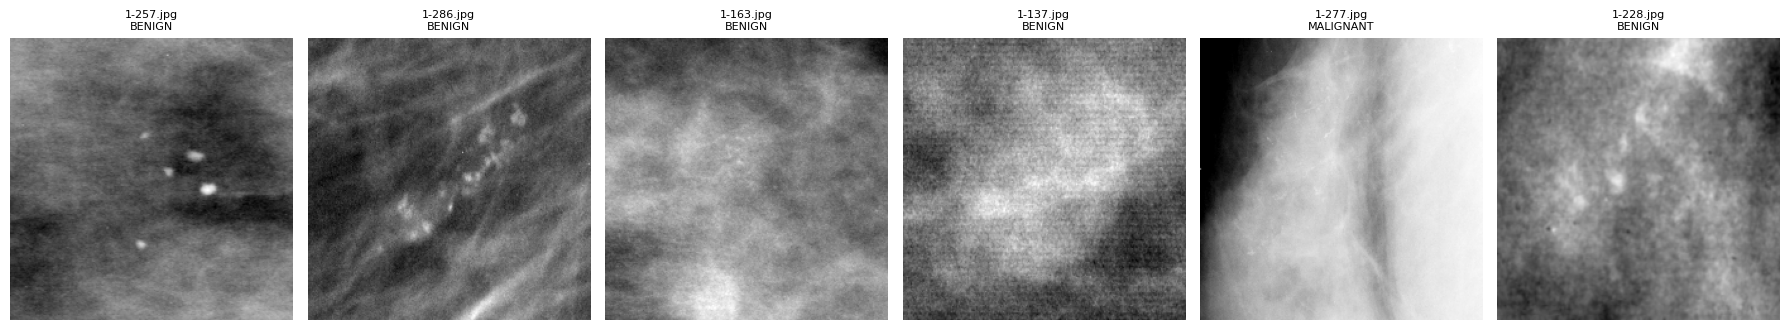


Folder names for displayed images:
1. 1.3.6.1.4.1.9590.100.1.2.206320643512456142422128034601269161990
2. 1.3.6.1.4.1.9590.100.1.2.163248818111673269135510314783078467343
3. 1.3.6.1.4.1.9590.100.1.2.154910982412150612305794433892250666746
4. 1.3.6.1.4.1.9590.100.1.2.200674905911357193327065189363002199745
5. 1.3.6.1.4.1.9590.100.1.2.122749525511723155739757812653038700602
6. 1.3.6.1.4.1.9590.100.1.2.260097167111163597619865862880949123212


In [30]:


def show_random_examples(df, img_col="fixed_image_path", label_col="pathology", n=6, size=224):
    n = min(n, len(df))
    idxs = random.sample(range(len(df)), n)
    rows = [df.iloc[i] for i in idxs]

    plt.figure(figsize=(3*n, 3.5))
    folder_names = []

    for i, row in enumerate(rows):
        try:
            img = cv2.imread(row[img_col], cv2.IMREAD_GRAYSCALE)
            if img is None:
                raise ValueError("cv2.imread returned None")
            img = cv2.resize(img, (size, size))

            # Grab folder + file names
            folder_name = os.path.dirname(row[img_col]).split("/")[-1]
            file_name = os.path.basename(row[img_col])

            plt.subplot(1, n, i+1)
            plt.imshow(img, cmap="gray")
            plt.title(f"{file_name}\n{row[label_col]}", fontsize=8)
            plt.axis("off")

            folder_names.append(folder_name)

        except Exception as e:
            plt.subplot(1, n, i+1)
            plt.text(0.5, 0.5, f"Load error:\n{os.path.basename(row[img_col])}\n{e}",
                     ha="center", va="center", fontsize=8)
            plt.axis("off")
            folder_names.append("Load error")

    plt.tight_layout()
    plt.show()

    # Print folder names underneath the figure
    print("\nFolder names for displayed images:")
    for i, fn in enumerate(folder_names, 1):
        print(f"{i}. {fn}")

# Show a few random samples
show_random_examples(dicom_crops, img_col="fixed_image_path", label_col="pathology", n=6, size=224)


<br>**Split ROI data into Train/Validation/Test split in 70:15:15 ratio** 

In [31]:


# First split: train vs (val+test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# Second split: val vs test (each 15% of total)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print("Shapes:")
print("Train:", X_train.shape, y_train.shape)
print("Val:  ", X_val.shape, y_val.shape)
print("Test: ", X_test.shape, y_test.shape)

print("\nLabel distribution:")
print("Train:", np.bincount(y_train))
print("Val:  ", np.bincount(y_val))
print("Test: ", np.bincount(y_test))


Shapes:
Train: (2019, 224, 224, 1) (2019,)
Val:   (433, 224, 224, 1) (433,)
Test:  (433, 224, 224, 1) (433,)

Label distribution:
Train: [1000 1019]
Val:   [214 219]
Test:  [215 218]


<br>**Build and train scratch CNN model on only ROI crops**<br>
**Decription:** Scratch model constructed on only ROI crops

In [32]:
# Define a scratch ROI CNN
def build_ROI_cnn(input_shape=(224,224,1)):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation="relu", input_shape=input_shape),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(64, (3,3), activation="relu"),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(128, (3,3), activation="relu"),
        layers.MaxPooling2D((2,2)),

        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(1, activation="sigmoid")  # binary output
    ])

    # Compile the model
    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    return model

# Build model
ROI_cnn = build_ROI_cnn(input_shape=(224,224,1))
ROI_cnn.summary()

C:\Users\ganatrh\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)                    │ (None, 222, 222, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,168,513 (42.60 MB)

 Trainable params: 11,168,513 (42.60 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:

# Train the model
history = ROI_cnn.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1
)


Epoch 1/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 40s 604ms/step - accuracy: 0.5101 - loss: 0.8961 - val_accuracy: 0.5058 - val_loss: 0.6931
Epoch 2/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 40s 633ms/step - accuracy: 0.5169 - loss: 0.6943 - val_accuracy: 0.5312 - val_loss: 0.6921
Epoch 3/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 39s 613ms/step - accuracy: 0.5277 - loss: 0.6936 - val_accuracy: 0.5196 - val_loss: 0.6902
Epoch 4/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 40s 620ms/step - accuracy: 0.4990 - loss: 0.6937 - val_accuracy: 0.5150 - val_loss: 0.6891
Epoch 5/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 37s 580ms/step - accuracy: 0.5509 - loss: 0.6891 - val_accuracy: 0.5266 - val_loss: 0.6905
Epoch 6/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 39s 611ms/step - accuracy: 0.5347 - loss: 0.6873 - val_accuracy: 0.5266 - val_loss: 0.6918
Epoch 7/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 37s 585ms/step - accuracy: 0.5388 - loss: 0.6805 - val_accuracy: 0.5173 - val_loss: 0.6898
Epoch 8/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 45s 647ms/step - accuracy: 0.5167 - loss: 0.6890 - val_accu

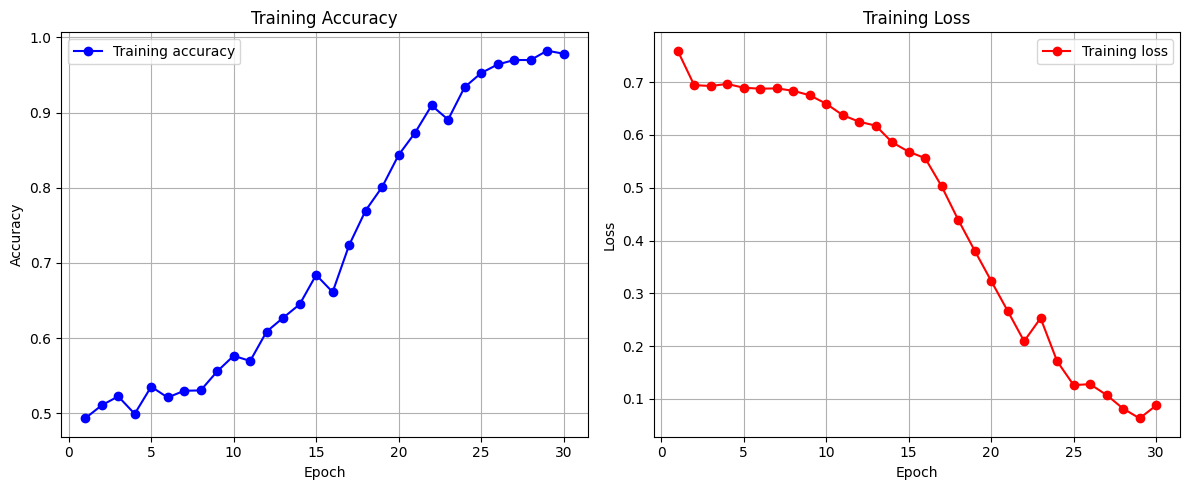

In [34]:
plot_training_curves(history)

<br>**Evaluating the Scratch ROI MODEL by generating evaluation metrics including Confusion Matrix**

In [35]:
test_loss, test_accuracy = ROI_cnn.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 174ms/step - accuracy: 0.5368 - loss: 4.4184
Test Accuracy: 0.5242
Test Loss: 4.5310


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step
              precision    recall  f1-score   support

      Benign       0.52      0.51      0.52       215
   Malignant       0.53      0.54      0.53       218

    accuracy                           0.52       433
   macro avg       0.52      0.52      0.52       433
weighted avg       0.52      0.52      0.52       433



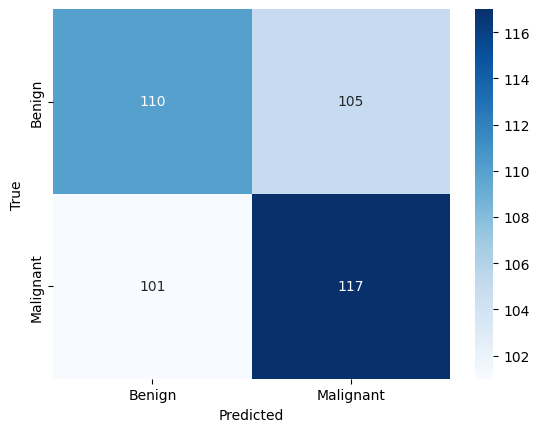

In [37]:
# Predictions
y_pred_probs = ROI_cnn.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int).ravel()

# Classification report
print(classification_report(y_test, y_pred, target_names=["Benign","Malignant"]))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Benign","Malignant"],
            yticklabels=["Benign","Malignant"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

<br>**Utilizing Transfer Learning to apply a VGG16 model to my problem, and retraining on my ROI dataset**

In [38]:


# Load pretrained VGG16 without the top classifier
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224,224,3))

# Freeze convolutional base
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification head
transfer_model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(1, activation="sigmoid")   # binary classification
])

# Compile
transfer_model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

transfer_model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,137,729 (80.63 MB)

 Trainable params: 6,423,041 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [39]:
history_transfer = transfer_model.fit(
    np.repeat(X_train, 3, axis=-1), y_train,    # repeat grayscale → RGB
    epochs=60,
    batch_size=32,
    validation_data=(np.repeat(X_val, 3, axis=-1), y_val),
    verbose=1
)


Epoch 1/60
64/64 ━━━━━━━━━━━━━━━━━━━━ 290s 5s/step - accuracy: 0.4998 - loss: 0.8193 - val_accuracy: 0.4965 - val_loss: 0.7023
Epoch 2/60
64/64 ━━━━━━━━━━━━━━━━━━━━ 305s 5s/step - accuracy: 0.5600 - loss: 0.6862 - val_accuracy: 0.5404 - val_loss: 0.6751
Epoch 3/60
64/64 ━━━━━━━━━━━━━━━━━━━━ 281s 4s/step - accuracy: 0.5565 - loss: 0.6856 - val_accuracy: 0.5173 - val_loss: 0.6923
Epoch 4/60
64/64 ━━━━━━━━━━━━━━━━━━━━ 286s 4s/step - accuracy: 0.5586 - loss: 0.6794 - val_accuracy: 0.5173 - val_loss: 0.6849
Epoch 5/60
64/64 ━━━━━━━━━━━━━━━━━━━━ 276s 4s/step - accuracy: 0.6220 - loss: 0.6524 - val_accuracy: 0.6166 - val_loss: 0.6537
Epoch 6/60
64/64 ━━━━━━━━━━━━━━━━━━━━ 273s 4s/step - accuracy: 0.6375 - loss: 0.6430 - val_accuracy: 0.6351 - val_loss: 0.6449
Epoch 7/60
64/64 ━━━━━━━━━━━━━━━━━━━━ 278s 4s/step - accuracy: 0.6303 - loss: 0.6382 - val_accuracy: 0.6282 - val_loss: 0.6459
Epoch 8/60
64/64 ━━━━━━━━━━━━━━━━━━━━ 295s 5s/step - accuracy: 0.6267 - loss: 0.6393 - val_accuracy: 0.6328 - v

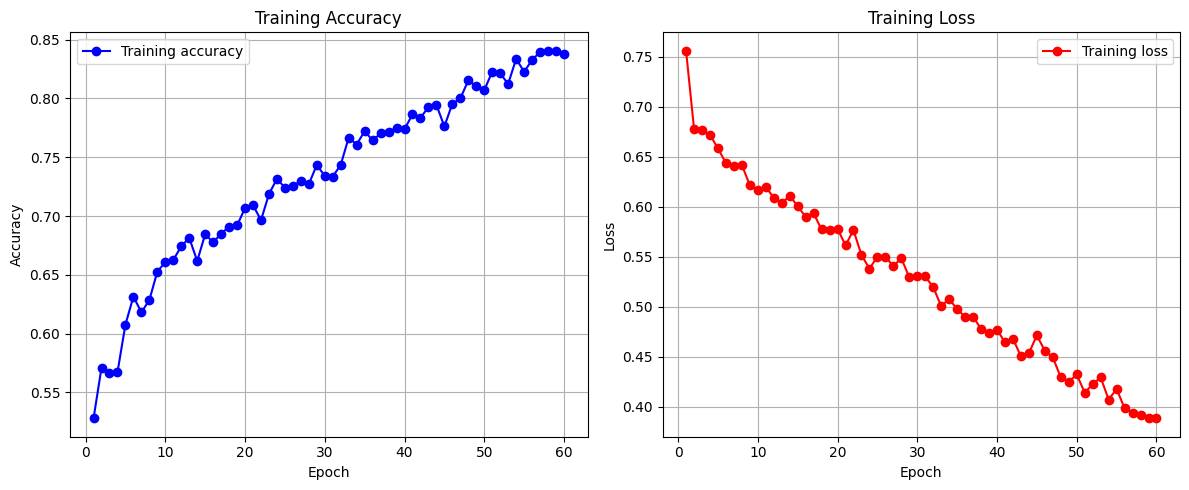

In [43]:
plot_training_curves(history_transfer)

<br>**Evaluate on the test set by generating evaluation metrics and confusion matrix**

In [41]:
# Prepare test set (grayscale → RGB)
X_test_rgb = np.repeat(X_test, 3, axis=-1)

# Evaluate performance
test_loss, test_acc = transfer_model.evaluate(X_test_rgb, y_test, verbose=1)

print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step - accuracy: 0.7000 - loss: 0.6008
Test Accuracy: 0.6767
Test Loss: 0.6277


14/14 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step
              precision    recall  f1-score   support

      Benign       0.63      0.82      0.72       215
   Malignant       0.75      0.53      0.62       218

    accuracy                           0.68       433
   macro avg       0.69      0.68      0.67       433
weighted avg       0.69      0.68      0.67       433



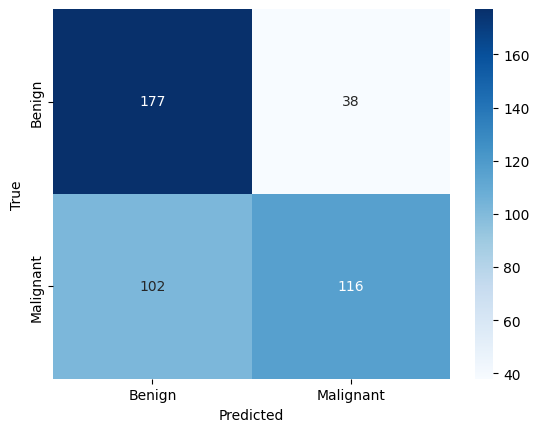

In [42]:
# Predictions
y_pred_probs = transfer_model.predict(X_test_rgb)
y_pred = (y_pred_probs > 0.5).astype(int).ravel()

# Classification report
print(classification_report(y_test, y_pred, target_names=["Benign","Malignant"]))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Benign","Malignant"],
            yticklabels=["Benign","Malignant"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()